In [2]:
import os
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import kagglehub
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dropout, concatenate, UpSampling2D
import cv2
from tensorflow.keras.preprocessing.image import load_img,img_to_array
path = kagglehub.dataset_download("abdallahwagih/retina-blood-vessel")

print("Path to dataset files:", path)
os.listdir(path)

Path to dataset files: /root/.cache/kagglehub/datasets/abdallahwagih/retina-blood-vessel/versions/1


['Data']

In [37]:
data_path = os.path.join(path, "Data")
train_path = os.path.join(data_path, "train")
test_path = os.path.join(data_path, "test")

In [38]:
def load_data(path,img_size):
    images = []
    masks = []
    for img_files,mask_files in zip(os.listdir(path+"/image"),os.listdir(path+"/mask")):
        img_path = os.path.join(path+"/image",img_files)
        mask_path = os.path.join(path+"/mask",mask_files)

        img = load_img(img_path,target_size=img_size)
        mask = load_img(mask_path,target_size=img_size,color_mode="grayscale")

        img = img_to_array(img)/255.0
        mask = img_to_array(mask)/255.0

        images.append(img)
        masks.append(mask)
    return np.array(images),np.array(masks)

In [39]:
train_images,train_masks = load_data(train_path,(256,256))
test_images,test_masks = load_data(test_path,(256,256))

In [40]:
print("Train images shape:",train_images.shape)
print("Train masks shape:",train_masks.shape)
print("Test images shape:",test_images.shape)
print("Test masks shape:",test_masks.shape)

Train images shape: (80, 256, 256, 3)
Train masks shape: (80, 256, 256, 1)
Test images shape: (20, 256, 256, 3)
Test masks shape: (20, 256, 256, 1)


In [41]:
def unet_model(input_size):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv9)

    return model

model = unet_model(input_size=(256, 256, 3))

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 128)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 256)    │              0 │ conv2d_28[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 512)    │              0 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 512)    │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_31[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 1024)   │              0 │ conv2d_32[0][0]        │
├──────────────────────

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [43]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=15,mode="min",verbose=1,restore_best_weights=True),tf.keras.callbacks.ModelCheckpoint("best_model.keras", monitor='val_loss',
                             save_best_only=True, mode='min', verbose=1)]

In [44]:
history = model.fit(train_images,train_masks,validation_data=(test_images,test_masks),epochs=50,callbacks=callbacks)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3578 - loss: 10.4340
Epoch 1: val_loss improved from inf to 0.51522, saving model to best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.4057 - loss: 15.3056 - val_accuracy: 0.8770 - val_loss: 0.5152
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8759 - loss: 0.5439
Epoch 2: val_loss did not improve from 0.51522
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8761 - loss: 0.5503 - val_accuracy: 0.8770 - val_loss: 0.6183
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8756 - loss: 0.6166
Epoch 3: val_loss did not improve from 0.51522
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8759 - loss: 0.6160 - val_accuracy: 0.8770 - val_loss: 0.5921
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8781 - loss: 0.5827
Epoch 4: val_loss improved from 0.51522 to 0.47088, saving model to best_model.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.8778 - loss: 0.5802 - val_

In [45]:
def plot_history(history):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

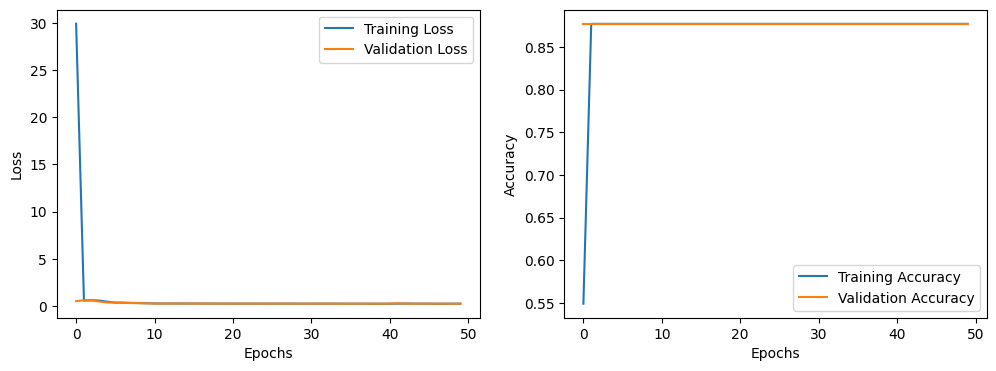

In [46]:
plot_history(history)

In [47]:
pred = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


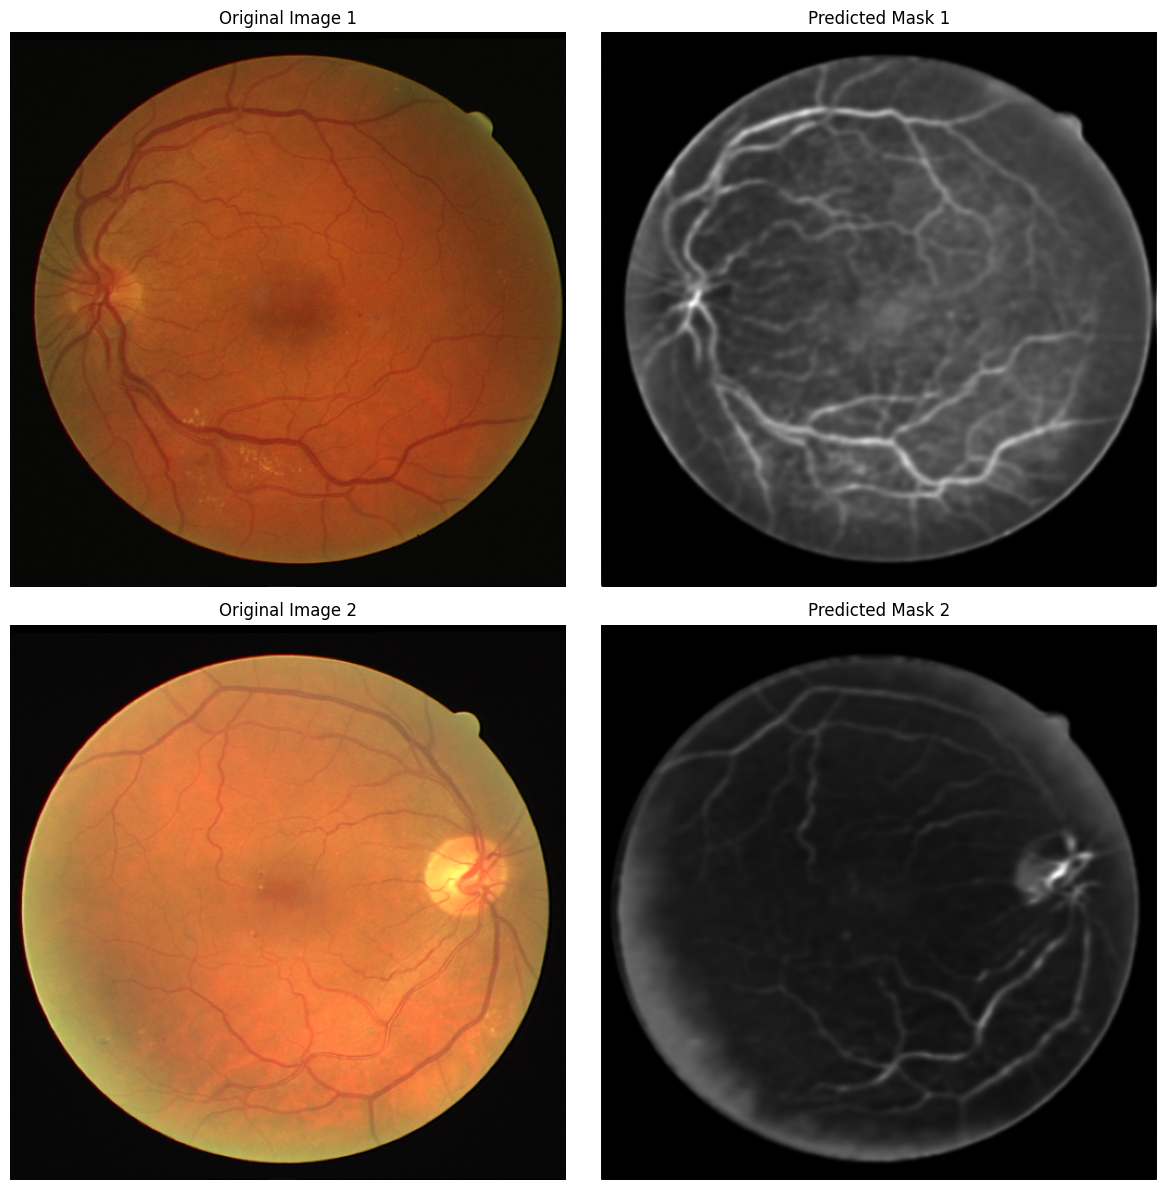

In [50]:
img_paths = ["/root/.cache/kagglehub/datasets/abdallahwagih/retina-blood-vessel/versions/1/Data/test/image/2.png",
             "/root/.cache/kagglehub/datasets/abdallahwagih/retina-blood-vessel/versions/1/Data/test/image/16.png"]

plt.figure(figsize=(12, 12))

for i, img_path in enumerate(img_paths):
    img = load_img(img_path, target_size=(512, 512))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)

    prediction_mask = np.squeeze(prediction)


    plt.subplot(2, 2, 2*i + 1)
    plt.imshow(img_array[0])
    plt.axis('off')
    plt.title(f'Original Image {i + 1}')

    plt.subplot(2, 2, 2*i + 2)
    plt.imshow(prediction_mask, cmap='gray')
    plt.axis('off')
    plt.title(f'Predicted Mask {i + 1}')

plt.tight_layout()
plt.show()